# wind stress of ERA data

In [75]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from ipdb import set_trace as mybreak
import pyicon as pyic
import cartopy.crs as ccrs
import glob
import pickle
import maps_icon_smt_temp as smt
import datetime
from matplotlib.patches import Rectangle
import cfgrib
import xarray as xr
import pandas as pd
import gsw
import matplotlib.gridspec as gridspec
from icon_smt_levels import dzw, dzt, depthc, depthi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### wind stress

In [2]:
path_data = '/work/mh0033/u241317/smt/forcing/ustressSel.nc'
ustress = xr.open_dataset(path_data)

In [3]:
path_data = '/work/mh0033/u241317/smt/forcing/vstressSel.nc'
vstress = xr.open_dataset(path_data)

In [2]:
path_data    = '/work/mh0033/u241317/smt/forcing/ustress.nc'
Ustress = xr.open_dataset(path_data)
Ustress

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables:
    var180   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 19 14:06:46 2021: cdo -f nc copy ERA5_ustress_1h_20...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [3]:
path_data    = '/work/mh0033/u241317/smt/forcing/vstress.nc'
Vstress = xr.open_dataset(path_data)
Vstress

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables:
    var181   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 19 14:09:03 2021: cdo -f nc copy ERA5_vstress_1h_20...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [6]:
#lon_regm2 = [180-65, 180-60]
tstart  = np.datetime64('2010-03-15T21:00:00')
tend    = np.datetime64('2010-03-22T21:00:00')
ustress = Ustress.loc[dict(time=slice(tstart, tend))]
ustress = ustress.assign_coords(lon=(((ustress.lon + 180) % 360) - 180))
ustress = ustress.sel(lon=slice(lon_reg[0],lon_reg[1]))
ustress = ustress.sel(lat=slice(lat_reg[1],lat_reg[0]))
ustress

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 201, time: 169)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
  * lon      (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -30.5 -30.25 -30.0
  * lat      (lat) float64 60.0 59.75 59.5 59.25 59.0 ... 15.75 15.5 15.25 15.0
Data variables:
    var180   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 19 14:06:46 2021: cdo -f nc copy ERA5_ustress_1h_20...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [7]:
#lon_regm2 = [180-65, 180-60]
tstart  = np.datetime64('2010-03-15T21:00:00')
tend    = np.datetime64('2010-03-22T21:00:00')
vstress = Vstress.loc[dict(time=slice(tstart, tend))]
vstress = vstress.assign_coords(lon=(((vstress.lon + 180) % 360) - 180))
vstress = vstress.sel(lon=slice(lon_reg[0],lon_reg[1]))
vstress = vstress.sel(lat=slice(lat_reg[1],lat_reg[0]))
vstress = vstress.rename({'var181': 'var180'}) # only necessary for corrupted dims
vstress

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 201, time: 169)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
  * lon      (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -30.5 -30.25 -30.0
  * lat      (lat) float64 60.0 59.75 59.5 59.25 59.0 ... 15.75 15.5 15.25 15.0
Data variables:
    var180   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 19 14:09:03 2021: cdo -f nc copy ERA5_vstress_1h_20...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [8]:
windstress = np.sqrt(ustress**2 + vstress**2)
#windstress.to_netcdf(path='/work/mh0033/u241317/smt/forcing/windstress.nc', mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None, compute=True, invalid_netcdf=False)

In [9]:
# load calculated
ustress.to_netcdf(path='/work/mh0033/u241317/smt/forcing/ustressSelL.nc', mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None, compute=True, invalid_netcdf=False)
vstress.to_netcdf(path='/work/mh0033/u241317/smt/forcing/vstressSelL.nc', mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None, compute=True, invalid_netcdf=False)

### plots

#### config

In [5]:
ccrs_proj = ccrs.PlateCarree()
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
lon_reg = [-80, -30]
lat_reg = [15, 60]
lon_regm = [-65, -60]
lat_regm = [39, 41.5]
lon_regs = [-64.8, -64.4]
lat_regs = [39.6, 39.8]

(15.0, 60.0)

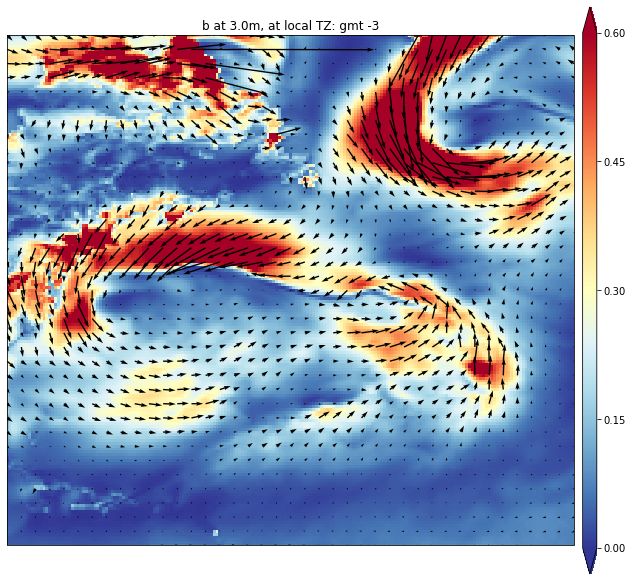

In [71]:
lon1 = lon_reg
lat1 = lat_reg
clim = np.array([0, 0.6])
lonw = ustress.lon.data
latw = ustress.lat.data
#X, Y = np.meshgrid(X, Y)
u4 = ustress.isel(time=10).var180.data
v4 = vstress.isel(time=10).var180.data
w4 = windstress.isel(time=10).var180.data
#hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)

hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=1, fig_size_fac=5,
                                 sharex=True, sharey=True, xlabel="", ylabel="",
                                 projection=ccrs_proj,
                                 dfigt=1.0, axlab_kw=None,
                                 )
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#fig, (ax0) = plt.subplots(figsize=(15,7.5))
#ax0 = pyic.shade(windstress.lon, windstress.lat, A.var180, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False,  cmap='RdYlBu_r')
hm4 = pyic.shade(lonw, latw, w4, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, clim=clim, cmap='RdYlBu_r')
ar = 5
hm5 = ax.quiver(lonw[::ar], latw[::ar], u4[::ar,::ar], v4[::ar,::ar])
ax.set_title('mag. windstress in N/m^2')
#ax.set_title('b at %.1fm'%(depthi[iz]), f'TimeZone: {timezone}')
ax.set_title(f'b at %.1fm, at local TZ: {timezone}'%(depthi[iz]))
ax.set_xlim(lon1)
ax.set_ylim(lat1)